In [47]:
import numpy as np
import os
import sys
import shutil
nexus_path = os.path.abspath("/Users/users/nastase/Applications/NEXUS_python/NEXUS_1.0/")
sys.path.append(nexus_path)
bin_path = os.path.abspath("/Users/users/nastase/Applications/NEXUS_python/NEXUS_1.0/bin/")
sys.path.append(bin_path)
from density import readDensityHeader, writeDensityData
import re
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [48]:
gridsize = 512
sidelen = 106.5
snapnum = 133
h = 0.704
L = 75000/h
data_directory = "/Users/users/nastase/PROJECT/DATA/nexus_outputs/MMF_outputs/"
base_path = "/Users/users/nastase/PROJECT/"

In [49]:
def giveheader(demoden,DTFEden,outputname,gridsize,sidelen):
    #First we read a file with a good header to edit
#     l = readDensityHeader("demo_density.a_den")
    l = readDensityHeader(demoden)
    #And we read the output from DTFE
    den = np.array(np.fromfile(DTFEden,dtype=np.float32))

    #And we put them in the header
    l.gridSize = np.array([gridsize,gridsize,gridsize])
    l.totalGrid = gridsize**3
    l.box = np.array([0.,sidelen,0.,sidelen,0.,sidelen])
    #Finally we write the new header with the density data to a new NEXUS-ready file
    writeDensityData(outputname,l,den)

In [50]:
def readNEXUS(densityFile,gridsize,vel=False,velFile=None):
    # here we wish to extract the 3 digits corresponding ot the snapshot number, such that we can save the files
    # in the same directory without overwriting
    
    pattern = r'(\d{3})\.a_den$'
    
    # Search for the pattern in the densityFile name
    match = re.search(pattern, densityFile)
    
    if match:
        # Extract the 3 digits
        digits = match.group(1)
#         print("Extracted digits: {digits}")
    else:
        print("No matching digits found before '.a_den'")
    
    #This function will read the files generated by runNEXUS and make them into numpy arrays
    #It can also read DTFE velocity files as an extra option
    #The order is as follows, it returns:
    #Densityfield, NEXUS_nodes, NEXUS_filaments, NEXUS_walls, Velocity (optional)
    #The NEXUS arrays can then be used for contours or converted into boolean arrays
    #Where all cells > 0 are part of the corresponding structure
    #Voids are located where the other three components are all 0 
    shape = (gridsize,gridsize,gridsize)
    denfield = np.fromfile(densityFile,dtype=np.float32)
    denfield = np.reshape(denfield[262:-2],shape)
    MMFn = np.fromfile(f"{data_directory}node_{digits}_clean.MMF",dtype=np.int16)
    MMFn = np.reshape(MMFn[527:-1],shape)
    MMFf = np.fromfile(f"{data_directory}fila_{digits}_clean.MMF",dtype=np.int16)
    MMFf = np.reshape(MMFf[527:-1],shape)
    MMFw = np.fromfile(f"{data_directory}wall_{digits}_clean.MMF",dtype=np.int16)
    MMFw = np.reshape(MMFw[527:-1],shape)
    #Correct for the z-axis missallignment of the density field wrt NEXUS
    def maxmean(densf,MMFfila,axisn,ran):
        k = np.zeros(ran)
        for i in range(ran):
            k[i] = np.mean(np.roll(densf,i,axis=axisn)[MMFfila>0])
        return np.argmax(k)
    
    shift = maxmean(denfield,MMFf,2,gridsize)
    denfield = np.roll(denfield,shift,axis=2)
    if vel==True:
        velo = np.fromfile(velFile,dtype=np.float32)
        k = np.reshape(velo,(gridsize,gridsize,gridsize,3))
        k = np.roll(k,shift,axis=2)
        return denfield, MMFn, MMFf, MMFw, k
    else:
        return denfield, MMFn, MMFf, MMFw

In [51]:
def generateMask(r, Nex):
    """
    Generates a mask array based on the positions in r and the values in Nex.
    
    Parameters:
    r (array-like): A list of vectors, each containing x, y, and z positions.
    Nex (3D array): A 3D numpy array where each dimension corresponds to x, y, or z. Values are either 1 or 0.
    
    Returns:
    mask (array): An array of 1s and 0s corresponding to whether each vector in r lies on a 1 or 0 in Nex.
    """
    # Convert r to a numpy array for easier manipulation
    r = np.array(r)
    
    # Ensure r is of shape (n, 3)
    if r.shape[1] != 3:
        raise ValueError("Each vector in r must have exactly 3 coordinates (x, y, z)")
    
    # Extract x, y, z coordinates from r
    x_coords = r[:, 0].astype(int)
    y_coords = r[:, 1].astype(int)
    z_coords = r[:, 2].astype(int)
    
    # Ensure the coordinates are within the bounds of Nex
    
    if (x_coords >= Nex.shape[0]).any() or (y_coords >= Nex.shape[1]).any() or (z_coords >= Nex.shape[2]).any():
        
        raise ValueError("Some coordinates in r are out of bounds of the Nex array")
    
    # Generate the mask by indexing into Nex
    mask = Nex[x_coords, y_coords, z_coords]
    
    return mask


In [52]:
#I try saving a copy of the original file, in case of bad writing practices of the program
tempfile = f"/Users/users/nastase/PROJECT/DATA/nexus_outputs/MMF_outputs/output_{snapnum}.a_den"

In [53]:
denfield, MMFn, MMFf, MMFw = readNEXUS(tempfile,gridsize)

In [71]:
MMFf[6,180,125]

0

In [72]:
MMFw[6,180,125]

0

In [67]:
np.round((positions_array - np.min(positions_array)) / (np.max(positions_array) - np.min(positions_array)) * 512)[0]

array([  6., 180., 125.], dtype=float32)

In [54]:
snap = il.snapshot.loadSubset(base_path, snapnum, 'dm', ["Coordinates", "ParticleIDs"])

In [55]:
positions_array = snap["Coordinates"]
ids_array = snap["ParticleIDs"]

In [56]:
maskMMFf = np.where(MMFf>0,1,0)

In [73]:
maskMMFf.shape[]

(512, 512, 512)

In [84]:
normalized_pos = ((positions_array - np.min(positions_array)) / (np.max(positions_array) - np.min(positions_array)) * 512) - 1

In [87]:
x_coords = normalized_pos[:,0].astype(int)
y_coords = normalized_pos[:,1].astype(int)
z_coords = normalized_pos[:,2].astype(int)

In [77]:
x_coords

array([  851.8552,   853.7293,   850.2726, ..., 60515.91  , 65718.586 ,
       63968.37  ], dtype=float32)

In [89]:
mask_for_filaments = maskMMFf[x_coords, y_coords, z_coords]

In [92]:
ids_array[mask_for_filaments==1]

array([15676632, 87471556, 84416862, ..., 94196360, 94196362, 94196369],
      dtype=uint64)

In [90]:
np.sum(mask_for_filaments)

42375013

In [12]:
positions_grid = snapToGrid(positions_array)

In [19]:
maskf = generateMask(positions_grid, maskMMFf)

In [22]:
filament_ids = ids_array[maskf==1]

In [47]:
def getMorphologicalIDs():
    """
    returns:
    
    f_ids: ids of particles in filaments
    w_ids: ids of particles in walls
    n_ids: ids of particles in nodes
    v_ids: ids of particles in voids
    """
    
    
    snap = il.snapshot.loadSubset(base_path, snapnum, 'dm', ["Coordinates", "ParticleIDs"])
    positions_array = snap["Coordinates"]
    ids_array = snap["ParticleIDs"]
    positions_grid = ((positions_array - np.min(positions_array)) / (np.max(positions_array) - np.min(positions_array)) * 512) - 1
    
    maskMMFf = np.where(MMFf>0, 1, 0)
    maskMMFw = np.where(MMFw>0, 1, 0)
    maskMMFn = np.where(MMFn>0, 1, 0)
    maskMMFv = np.where((MMFf == 0) & (MMFw == 0) & (MMFn == 0), 1, 0)
    
    maskf = generateMask(positions_grid, maskMMFf)
    maskw = generateMask(positions_grid, maskMMFw)
    maskn = generateMask(positions_grid, maskMMFn)
    maskv = generateMask(positions_grid, maskMMFv)
    
    f_ids = ids_array[maskf == 1]
    w_ids = ids_array[maskw == 1]
    n_ids = ids_array[maskn == 1]
    v_ids = ids_array[maskv == 1]
    
    return f_ids, w_ids, n_ids, v_ids

In [28]:
filaments, walls, nodes, voids = getMorphologicalIDs()

In [93]:
particle_id_dict = {
    'filaments': filaments,
    'walls': walls,
    'nodes': nodes,
    'voids': voids,
    'il_data': snap
}

NameError: name 'walls' is not defined

In [50]:
with open(f'/Users/users/nastase/PROJECT/DATA/nexus_outputs/particle_selecta/particle_ids_{snapnum}.pickle', 'wb') as handle:
    pickle.dump(particle_id_dict, handle, protocol=4)

In [31]:
snap["Coordinates"][filaments]

array([[151.18076  , 114.33869  , 216.1212   ],
       [141.3453   , 186.47826  , 256.54028  ],
       [103.399574 , 238.66466  , 152.47348  ],
       ...,
       [298.45917  , 149.30956  ,   3.6044421],
       [282.6569   ,   3.545743 , 184.66191  ],
       [292.6962   , 235.92052  , 274.53177  ]], dtype=float32)

In [32]:
np.shape(snap["Coordinates"][filaments])

(4532075, 3)

In [33]:
len(filaments)

4532075

In [ ]:
# def common_mass_fraction(f_ids, w_ids, n_ids, v_ids):
    

In [34]:
455**3

94196375

In [10]:
with open('/Users/users/nastase/PROJECT/DATA/nexus_outputs/particle_selecta/particle_ids_133.pickle', 'rb') as handle:
    loaded_ids_dict = pickle.load(handle)

In [14]:
filaments = loaded_ids_dict["filaments"]
coords = loaded_ids_dict["il_data"]["Coordinates"]

In [21]:
filament_coords = coords[filaments]

In [34]:
c = np.round((filament_coords - np.min(filament_coords)) / (np.max(filament_coords) - np.min(filament_coords)) * 512)

In [35]:
c

array([[215., 163., 308.],
       [201., 265., 365.],
       [147., 340., 217.],
       ...,
       [425., 213.,   5.],
       [402.,   5., 263.],
       [417., 336., 391.]], dtype=float32)

In [43]:
c[:, 1] == 20

array([False, False, False, ..., False, False, False])

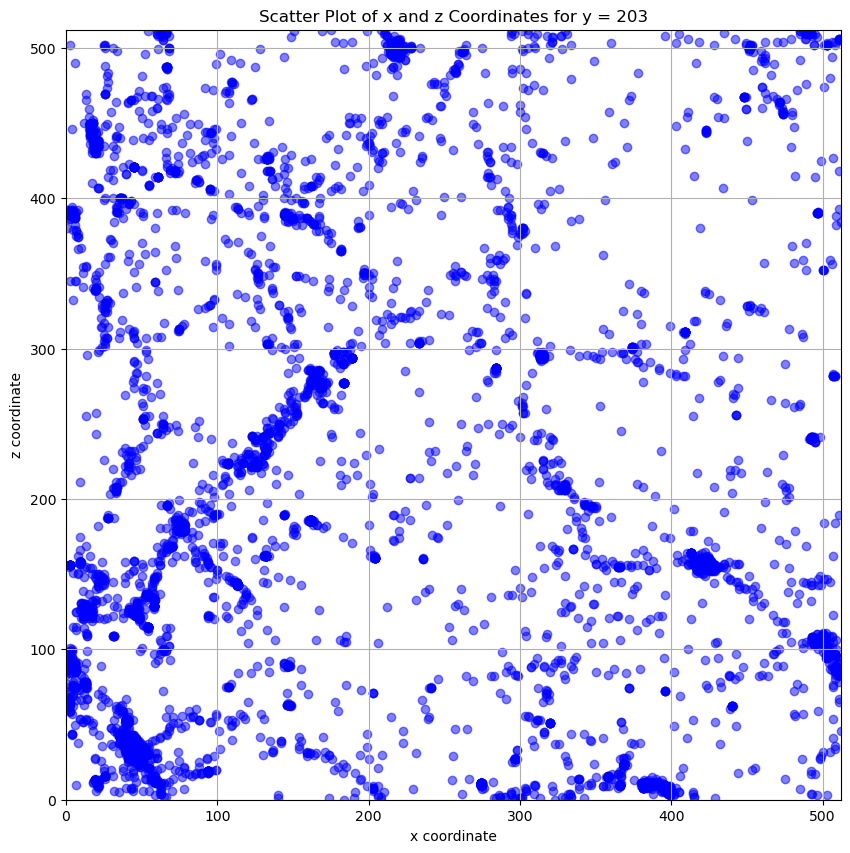

In [45]:
filtered_coords = c[c[:, 1] == 200]
x_coords = filtered_coords[:, 0]
z_coords = filtered_coords[:, 2]
plt.figure(figsize=(10, 10))
plt.ylim(0, 512)
plt.xlim(0,512)
plt.scatter(x_coords, z_coords, c='blue', alpha=0.5, marker='o')  # You can customize the plot
plt.title('Scatter Plot of x and z Coordinates for y = {0}'.format("203"))
plt.xlabel('x coordinate')
plt.ylabel('z coordinate')
plt.grid(True)
plt.show()